# TP4
## Grupo 15

Carlos Eduardo Da Silva Machado A96936

Gonçalo Manuel Maia de Sousa A97485

## Exercício 4.1

### Descrição do Problema

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.
2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
        Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.
3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.
4. É imprescindível evitar que o sistema tenha “trajetórias de Zenão”. Isto é, sequências  infinitas de transições  entre dois modos em intervalos de tempo  que tendem para zero mas nunca alcançam zero.

### Abordagem do Problema

1. Componentes Contínuas:
- velocidade linear das rodas
- velocidade do corpo (veículo)
- tempo
- timer

2. Componentes Discretas:
- Modo

3. Constantes:
- força de atrito do solo no modo block (baixa) e força de atrito nos restantes modos (alta)
- constante de proporcionalidade no modo stopping (alta) e nos restantes (baixa)
- velocidade inicial
- peso




eventos (aka nodos): Start, Free, Stopping, Blocked e Stopped
- Start -> Inicio
- Free -> A força de travagem não é exercida sobre o veículo
- Stopping -> É aplicada uma força de travagem alta sobre o veículo
- Blocked -> As rodas estão travadas, porém o veículo continua a mover-se
- Stopped -> O veículo pára

Jumps (ter em atenção o comportamento desejável: imobilize-se depressa e não “derrape” muito):
- Start -> Free (Inicia para um movimento livre)
- Stopping -> Blocked (O véiculo começa a derrapar)
- Blocked -> Free
- Stopping -> blocked



## Código Python

conda install -c alubbock pygraphviz

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import *
import matplotlib.pyplot as matplot

Start = Int(-1)
Free = Int(0)
Stopping = Int(1)
Blocked = Int(2)
Stopped = Int(3)

V0 = 20
aBlocked = 0.1
a = 0.5
cStopping = 7
c = 0.5
Tau = 1.0
P = 1000
dif = 0.5 # intervalo entre velocidade do corpo e das rodas
delta = 0.01 # intervalo entre os tempos

In [2]:
def simulation(a, b, c1, c2, dt, dif, P, tau, time, v0):
    V = v0
    v = v0
    t = 0
    V_ = [V]
    v_ = [v]
    T = [t]
    timer = 0
    m = Free
    
    while(t<time and (V>0 or v>0)):
        
        if m == Stopping and (V - v < dif )  :
            m = Blocked
        
        elif timer >= tau and m == Blocked:
            m = Free
            timer = 0
        
        elif timer >= tau and m == Free:
            m = Stopping
            timer = 0 
        
        
        if m == Free:
            V, v = V + (-c2*(V-v))*dt, v + (-b*P + c2*(V-v))*dt
        
        elif m == Stopping:
            V, v = V + (-c1*(V-v))*dt, v + (-b*P + c1*(V-v))*dt
        
        else:
            V, v = v + (-b*P)*dt, v + (-b*P)*dt
    
        
        t += dt
        timer += dt
        V_.append(V)
        v_.append(v)
        T.append(t)
        
    
    matplot.plot(T,V_,T,v_)
    matplot.title("Gráfico com a evolução das constantes")
    matplot.xlabel("Tempo (s)")
    matplot.ylabel("Velocidade (m/s)")
    matplot.legend(["Velocidade do corpo", "Velocidade linear das rodas"], loc ="best")
    matplot.grid(True)



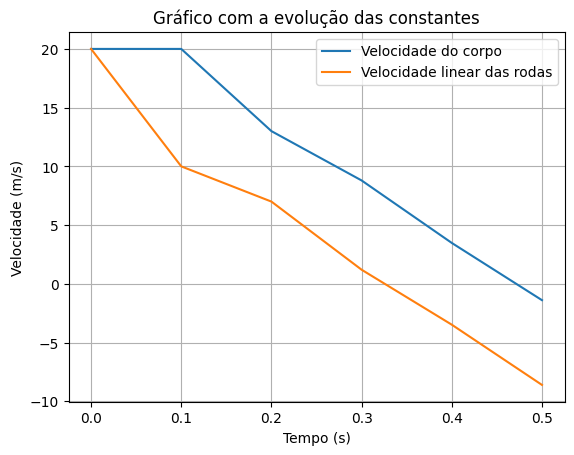

In [3]:
maxtime = 20
timediference = 0.1
simulation(a,aBlocked, c, cStopping, timediference, dif, P, Tau, maxtime, V0)

In [4]:
def declare(i):
    s = {}
    # Discretas
    s['m'] = Symbol('m'+str(i),INT) # Modo
    # Contínuas
    s['t'] = Symbol('t'+str(i),REAL) # Tempo
    s['V'] = Symbol('V'+str(i),REAL) # Velocidade do corpo
    s['v'] = Symbol('v'+str(i),REAL) # velocidade linear das rodas
    s['timer'] = Symbol('timer'+str(i),REAL) # Timer
    return s

In [5]:
def init(s):
    return And(Equals(s['m'], Start),Equals(s['t'],Real(0)), Equals(s['V'], Real(V0)), Equals(s['v'], Real(V0)))

In [6]:
def trans1(s,p):
    # untimed
    
    StartToFree = And(Equals(s['m'], Start),
                      Equals(p['m'], Free),
                      Equals(p['timer'],Real(0)),
                      Equals(p['V'], s['V']),
                      Equals(p['v'], s['v']),
                      Equals(p['t'], s['t']))
    
    FreeToStopping = And(Equals(s['m'], Free),
                         Equals(p['m'], Stopping),
                         Equals(p['V'], s['V']),
                         Equals(p['v'], s['v']),
                         Equals(p['t'], s['t']),
                         s['timer'] >= Real(Tau),
                         Equals(p['timer'],s['timer']))
    
    StoppingToBlocked = And(Equals(s['m'], Stopping),
                            Equals(p['m'], Blocked),
                            s['V']-s['v'] < Real(dif),
                            Equals(p['V'], s['V']),
                            Equals(p['v'], s['v']),
                            Equals(p['t'], s['t']),
                            Equals(p['timer'],Real(0)))
    
    BlockedToFree = And(Equals(s['m'], Blocked),
                        Equals(p['m'], Free),
                        Equals(p['V'], s['V']),
                        Equals(p['v'], s['v']),
                        Equals(s['timer'],Real(Tau)),
                        Equals(p['timer'],Real(0)),
                        Equals(p['t'], s['t']))
    
    StoppingToStopped = And(Equals(s['m'], Stopping),
                            Equals(p['m'], Stopped),
                            Equals(p['V'], s['V']),
                            Equals(p['v'], s['v']),
                            Equals(p['t'], s['t']),
                            p['V'] < Real(dif),
                            p['v'] < Real(dif),
                            Equals(p['timer'],s['timer']))
    
    # timed
    
    FreeFree = Or([And(Equals(s['m'], Free),
                   Equals(p['m'], Free),
                   s['V'] >= 0, p['V'] >= 0, s['v'] >= 0, p['v'] >= 0,
                   s['V']-s['v']<i+0.5, s['V']-s['v']>=i-0.5,
                   Equals(p['V']-s['V'], -(Real(c) * i) * (p['t'] - s['t'])),
                   Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(c) * i)) * (p['t'] - s['t'])), 
                   p['t']>s['t'],
                   p['timer'] < Tau,
                   Equals(p['timer'],s['timer'] + p['t'] - s['t'])) for i in range(0,V0+1)])
    
    StoppingStopping = Or([And(Equals(s['m'], Stopping),
                       Equals(p['m'], Stopping),
                       s['V'] >= 0, p['V'] >= 0, s['v'] >= 0, p['v'] >= 0,
                       s['V']-s['v']<i+0.5, s['V']-s['v']>=i-0.5,
                       Equals(p['V']-s['V'], -(Real(cStopping) * i) * (p['t'] - s['t'])),
                       Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(cStopping) * i)) * (p['t'] - s['t'])),
                       p['t']>s['t'],
                       p['timer'] < Tau,
                       Equals(p['timer'],s['timer'])) for i in range(0,V0+1)])
    
    BlockedBlocked = And(Equals(s['m'], Blocked),
                         Equals(p['m'], Blocked),
                         Equals(p['V'],s['v']),
                         s['V'] >= 0, p['V'] >= 0, s['v'] >= 0, p['v'] >= 0,
                         Equals(p['v']-s['v'], (-Real(aBlocked) * Real(P)) * (p['t'] - s['t'])),
                         p['t']>s['t'],
                         Equals(p['timer'],s['timer'] + p['t'] - s['t']))

    return Or(StartToFree, FreeToStopping, StoppingToBlocked, BlockedToFree, StoppingToStopped, FreeFree, StoppingStopping, BlockedBlocked)
    

In [7]:
def trans(s,p):
    #untimed
    
    StartToFree = And(Equals(s['m'],Start), Equals(p['m'],Free),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                     Equals(p['timer'],Real(0)))
    
    
    #FreeToStopping  =  And(s['m']==Free, p['m']==Stopping ,s['t']==p['t'], s['V']>Real(0),s['v']>=Real(0), 
    #                   s['V']==p['V'], s['v']==p['v'], s['timer']>=Real(Tau))
    
    FreeToStopping = And(Equals(s['m'], Free),
                         Equals(p['m'], Stopping),
                         Equals(p['V'], s['V']),
                         Equals(p['v'], s['v']),
                         Equals(p['t'], s['t']),
                         s['timer'] >= Real(Tau))
    
    StoppingToBlocked = And(Equals(s['m'],Stopping), Equals(p['m'],Blocked),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                     Equals(p['timer'],Real(0)), s['V']-s['v']<Real(dif))
    
    BlockedToFree = And(Equals(s['m'],Blocked), Equals(p['m'],Free),Equals(s['t'],p['t']), Equals(s['V'],p['V']),
                        Equals(s['v'],p['v']), s['timer']>=Real(Tau), 
                       Equals(p['timer'],Real(0)))
    
    StoppingToStopped = And(Equals(s['m'],Stopping), Equals(p['m'],Stopped),Equals(s['t'],p['t']),
                           s['V']<Real(dif), s['v']<Real(dif), Equals(p['V'],Real(0)), Equals(p['v'],Real(0)))
    
    #timed
    
    StoppingStopping = Or([And(Equals(s['m'],Stopping),Equals(p['m'],Stopping),p['t']>s['t'],
                        s['V']-s['v']>=Real(dif), 
                        p['V']-p['v']>=Real(0),   
                        s['V']>=Real(0),s['v']>=Real(0), 
                        p['V']>=Real(0), p['v']>=Real(0),
                        s['V']-s['v']<Real(i+0.5), s['V']-s['v']>=Real(i-0.5), 
                        Equals(p['V']-s['V'], -(Real(cStopping) * Real(i)) * (p['t'] - s['t'])),
                        Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(cStopping) * Real(i))) * (p['t'] - s['t']))) for i in range(V0+1)])
    
    
    
    """FreeFree = Or([And(s['m']==Free,p['m']==Free,p['t']>s['t'], s['V']>=Real(0),s['v']>=Real(0),
                        p['V']>=Real(0), p['v']>=Real(0), 
                        p['timer']<=Tau,p['timer']==s['timer']+p['t']-s['t'], 
                        s['V']-s['v']<Real(i+0.5), s['V']-s['v']>=Real(i-0.5), 
                        Equals(p['V']-s['V'], -(Real(c) * Real(i)) * (p['t'] - s['t'])),
                        Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(c) * Real(i))) * (p['t'] - s['t']))) for i in range(V0+1)])
    """
    
    FreeFree = Or([And(Equals(s['m'], Free),
                   Equals(p['m'], Free),
                   s['V'] >= Real(0), p['V'] >= Real(0), s['v'] >= Real(0), p['v'] >= Real(0),
                   s['V']-s['v']<Real(i+0.5), s['V']-s['v']>=Real(i-0.5),
                   Equals(p['V']-s['V'], -(Real(c) * i) * (p['t'] - s['t'])),
                   Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(c) * i)) * (p['t'] - s['t'])), 
                   p['t']>s['t'],
                   p['timer'] <= Tau,
                   Equals(p['timer'],s['timer'] + p['t'] - s['t'])) for i in range(0,V0+1)])
    
    """BlockedBlocked = And(s['m']==Blocked,p['m']==Blocked,p['t']>s['t'],s['V']>=Real(0),s['v']>=Real(0),
                          p['V']>=Real(0), p['v']>=Real(0), 
                          p['timer']<=Real(Tau),p['timer']==s['timer']+p['t']-s['t'],
                          Equals(p['v']-s['v'], (-Real(aBlocked) * Real(P)) * (p['t'] - s['t'])), 
                          Equals(p['V']-s['V'], (-Real(aBlocked) * Real(P)) * (p['t'] - s['t']))) 
    """
    
    BlockedBlocked = And(Equals(s['m'], Blocked),
                         Equals(p['m'], Blocked),
                         s['V'] >= Real(0), p['V'] >= Real(0), s['v'] >= Real(0), p['v'] >= Real(0),
                         Equals(p['V']-s['V'], (-Real(aBlocked) * Real(P)) * (p['t'] - s['t'])),
                         Equals(p['v']-s['v'], (-Real(aBlocked) * Real(P)) * (p['t'] - s['t'])),
                         p['t']>s['t'],
                         Equals(p['timer'],s['timer'] + p['t'] - s['t']))
                          
    
    return Or(StartToFree, FreeToStopping, StoppingToBlocked, BlockedToFree, StoppingToStopped, FreeFree, StoppingStopping, BlockedBlocked)
    

In [8]:
def gera_traco(declare,init,trans,k):

    with Solver(name="z3") as s:
    
        # completar
    
        # cria k copias do estado
        trace = [declare(i) for i in range(k)]
    
        # criar o traço
        s.add_assertion(init(trace[0]))
        for i in range(k-1):
            s.add_assertion(trans(trace[i], trace[i+1]))
        
        if s.solve():
            for i in range(k):
                print()
                print("Modo:",i)
                m = s.get_py_value(trace[i]['m'])
                if m==1:
                    print("Stopping")
                elif m==2:
                    print("Blocked")
                    print("timer =", float(s.get_py_value(trace[i]['timer'])))
                elif m==0:
                    print("Free")
                    print("timer =", float(s.get_py_value(trace[i]['timer'])))
                elif m==3:
                    print("Stopped")
                else:
                    print("Start")
                    
                print("t =", float(s.get_py_value(trace[i]['t'])))
                print("V =", float(s.get_py_value(trace[i]['V'])))
                print("v =", float(s.get_py_value(trace[i]['v'])))
        else:
            print("Solver cannot solve")

In [9]:
gera_traco(declare,init,trans,10)


Modo: 0
Start
t = 0.0
V = 20.0
v = 20.0

Modo: 1
Free
timer = 0.0
t = 0.0
V = 20.0
v = 20.0

Modo: 2
Free
timer = 0.015
t = 0.015
V = 20.0
v = 12.5

Modo: 3
Free
timer = 0.035070872841209536
t = 0.035070872841209536
V = 19.91971650863516
v = 2.544847070760069

Modo: 4
Free
timer = 0.035329407060475874
t = 0.035329407060475874
V = 19.917518967771397
v = 2.417777501990664

Modo: 5
Free
timer = 0.03558794127974221
t = 0.03558794127974221
V = 19.915321426907635
v = 2.2907079332212597

Modo: 6
Free
timer = 0.03947878465383687
t = 0.03947878465383687
V = 19.880303836540783
v = 0.3803038365407822

Modo: 7
Free
timer = 0.03973731887310321
t = 0.03973731887310321
V = 19.87771849434812
v = 0.2536220691002769

Modo: 8
Free
timer = 0.03999585309236955
t = 0.03999585309236955
V = 19.875133152155456
v = 0.12694030165977163

Modo: 9
Free
timer = 0.040254387311635886
t = 0.040254387311635886
V = 19.872547809962793
v = 0.00025853421926633733


In [10]:
def bmc_always(declare,init,trans,prop,K):
    for k in range(1,K+1):
        with Solver(name="z3") as s:
            
            # completar
            trace = [declare(i) for i in range(k)]
    
            s.add_assertion(init(trace[0]))
            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1]))
            
            # 
            s.add_assertion(Not(prop(trace[k-1])))
            if s.solve():
                for i in range(k):
                    print()
                    print("State:",i)
                    m = s.get_py_value(trace[i]['m'])
                    if m==1:
                        print("Stopping")
                    elif m==2:
                        print("Blocked")
                        print("timer =", float(s.get_py_value(trace[i]['timer'])))
                    elif m==0:
                        print("Free")
                        print("timer =", float(s.get_py_value(trace[i]['timer'])))
                    elif m==3:
                        print("Stopped")
                    else:
                        print("Start")
                    
                    print("t =", float(s.get_py_value(trace[i]['t'])))
                    print("V =", float(s.get_py_value(trace[i]['V'])))
                    print("v =", float(s.get_py_value(trace[i]['v'])))
                return
                
    print("A propriedade é válida para traços de tamanho até " + str(k))